In [3]:
import numpy as np
import itertools
import time
import random
import pandas as pd
import importlib
import multiprocessing
import chromosome_simulation_code_soft_limit

import gc

In [4]:
from numba import jit
from numba.typed import List

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In /home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [6]:
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(list(np.linspace(0,1,numChrs))))
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 13}
fontLabel = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

In [7]:
importlib.reload(chromosome_simulation_code_soft_limit)
from chromosome_simulation_code_soft_limit import *

# Importing Data

In [8]:
inFile = "/home/derek/Dropbox/projects/markov_chromosomes/DToL_data/lep_chromosomes_lengths_20210604_by_taxon.DToL_autosomes.tsv";
df = pd.read_csv(inFile,sep='\t',header = 0, names = ['species','sample_id','length']);

def format_lep_df(thisDF):
    new_df = pd.DataFrame()
    new_df["Species"] = thisDF["species"]
    k = len(new_df)
    new_df["chromosome number"]=k
    new_df["chromosome index"] = list(range(1,k+1))
    
    lengths = thisDF["length"]
    lengths = np.sort(lengths)
    lengths = lengths/sum(lengths)
    new_df["relative size"] = lengths
#     new_df["index"] = [i/(k+1) for i in range(1,k+1)]

#     mean = np.mean(new_df["relative size"])
#     new_df["mean_norm"] = new_df["relative size"]/mean
    
    return(new_df)

formatted = [format_lep_df(y) for x,y in df.groupby('species')]

dfLep = pd.concat(formatted)





inFile2 = "/home/derek/Dropbox/projects/markov_chromosomes/chromsome_length_tables/msr011_Supplementary_Data/supplement_tableS2_0320_1.csv"
df1 = pd.read_csv(inFile2,sep=',',header = 0);

def simplify_this_df(thisDF):
    new_df = pd.DataFrame()
    new_df["Species"] = thisDF["Species"]
    new_df["chromosome number"] = thisDF["Chromosome number"]
    new_df["chromosome index"] = thisDF["Chromosome\nindex"]
    tot = sum(thisDF["Chromosome\nsize"])
    new_df["relative size"] = thisDF["Chromosome\nsize"]/tot
    k = len(new_df)
#     new_df["index"] = [i/(k+1) for i in range(1,k+1)]
#     mean = np.mean(new_df["relative size"])
#     new_df["mean_norm"] = new_df["relative size"]/mean
    return(new_df)

df2 = df1[df1["Common name"] != "Prokaryotes"]
simplified = [simplify_this_df(y) for x, y in df2.groupby('Species')]
dfEuk = pd.concat(simplified)



inFile = "/home/derek/Dropbox/projects/markov_chromosomes/heliconius_data/heliconius_data.csv"
df3 = pd.read_csv(inFile,sep=',',header = 0)
speciesNames = df3.columns.values.tolist()
sizeDistList = []
for name in speciesNames:
    sizes = list(df3[name])
    sizes = np.array(sizes)
    total = sum(sizes)
    relSizes = sizes/total
    relSizes = np.sort(relSizes)
    k = len(relSizes)
    for idx, val in enumerate(relSizes):
        chrId = idx+1
        sizeDistList.append([name,k,chrId,val])
sizeDistList

dfHel = pd.DataFrame(sizeDistList, columns = ["Species","chromosome number","chromosome index","relative size"])
dfHel


dfCombined = pd.concat([dfEuk,dfLep,dfHel])
dfCombined

Species  chromosome number  chromosome index  relative size
106  Anopheles gambiae                2.0               1.0       0.461797
107  Anopheles gambiae                2.0               2.0       0.538203
447     Apis mellifera               16.0               1.0       0.030101
448     Apis mellifera               16.0               2.0       0.041996
449     Apis mellifera               16.0               3.0       0.044467
..                 ...                ...               ...            ...
315            H. sara               20.0              16.0       0.062821
316            H. sara               20.0              17.0       0.064257
317            H. sara               20.0              18.0       0.067124
318            H. sara               20.0              19.0       0.067605
319            H. sara               20.0              20.0       0.068554

[3346 rows x 4 columns]

In [9]:
minMaxSizes = []
speciesNames = dfCombined["Species"].unique()
for species in speciesNames:
    dfx = dfCombined[dfCombined["Species"] == species]
    sizes = list(dfx["relative size"])
    cmin = min(sizes)
    cmax= max(sizes)
    k = len(dfx)
    minMaxSizes.append([species,k,cmin,cmax])
minMaxSizes

[['Anopheles gambiae', 2, 0.4617968655453204, 0.5382031344546796],
 ['Apis mellifera', 16, 0.030101360211122082, 0.13820684840308917],
 ['Arabidopsis lyrata', 8, 0.09949857894110653, 0.17062593821947047],
 ['Arabidopsis thaliana', 5, 0.15598510833080675, 0.255380643307674],
 ['Ashbya gossypii', 7, 0.07914545963663916, 0.2073981193230588],
 ['Aspergillus fumigatus', 8, 0.06238307368007809, 0.16739785709409555],
 ['Aspergillus nidulans', 8, 0.09472934276671255, 0.16185796185105333],
 ['Aspergillus niger', 8, 0.08866594694238478, 0.17799698585423235],
 ['Aspergillus oryzae', 8, 0.07720866904409651, 0.17162209009867652],
 ['Babesia bovis', 2, 0.40007481367716163, 0.5999251863228384],
 ['Bigelowiella natans', 3, 0.263190924450881, 0.37704830101644005],
 ['Bos taurus', 29, 0.017306438110765092, 0.06328074719918886],
 ['Brachypodium distachyon', 5, 0.1049033679616616, 0.2759914463821798],
 ['Caenorhabditis elegans', 5, 0.16696695327484817, 0.25346205800433014],
 ['Candida dubliniensis', 8, 0.

In [10]:
modelMins = [0.4035*1/y for y in range(2,100)]
modelMaxs = [1.8626*1/y for y in range(2,100)]

temp = []
for xs in minMaxSizes:
    sp,kk,dmin,dmax = xs
    tooSmall = "no"
    tooBig = "no"
    
    mmin = modelMins[kk-2]
    mmax = modelMaxs[kk-2]

    if dmin<mmin:
        tooSmall = "yes"
    if dmax>mmax:
        tooBig = "yes"
        
    temp.append([sp,kk,tooSmall,tooBig])
dfSizeCheck = pd.DataFrame(temp,columns = ["species","k","too small","too big"])


print(len(dfSizeCheck[(dfSizeCheck["too small"]=='yes') | (dfSizeCheck["too big"]=='yes')]
))
dfSizeCheck[(dfSizeCheck["too small"]=='yes') | (dfSizeCheck["too big"]=='yes')]


33


species   k too small too big
1                  Apis mellifera  16        no     yes
16               Canis familiaris  38        no     yes
21        Cyanidioschyzon merolae  20        no     yes
22               Cyanothece sp. 2   2       yes      no
28                 Equus caballus  31       yes     yes
29                Gallus gallus 1  30       yes     yes
34                   Homo sapiens  22       yes     yes
37        Leishmania braziliensis  35       yes     yes
41           Micromonas sp.RCC299  17       yes      no
44   Mycosphaerella graminicola 3  21       yes     yes
45     Ornithorhynchus anatinus 1  19       yes     yes
48       Ostreococcus lucimarinus  21       yes      no
49             Ostreococcus tauri  20       yes      no
50                Pan troglodytes  23       yes     yes
51      Phaeodactylum tricornutum  33       yes     yes
54            Plasmodium knowlesi  14        no     yes
55               Plasmodium vivax  14        no     yes
56                 Pongo pygmaeus  22       yes     yes
57            Populus trichocarpa  19       yes     yes
58              Rattus norvegicus  20       yes     yes
59       Saccharomyces cerevisiae  16       yes     yes
62                     Sus scrofa  18        no     yes
63          Taeniopygia guttata 1  29       yes     yes
64       Thalassiosira pseudonana  20       yes     yes
67            Tribolium castaneum  10        no     yes
68             Trypanosoma brucei  10        no     yes
85            Celastrina_argiolus  25       yes      no
88               Cosmia_trapezina  31       yes      no
91           Deilephila_porcellus  28       yes      no
100               Hedya_salicella  24        no     yes
107              Leptidea_sinapis  47        no     yes
121         Notocelia_uddmanniana  27        no     yes
132              Pieris_brassicae  14       yes      no

# function for processing and plotting

In [17]:
def make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta):
    

    thisModel_nChrs = []
    for x1 in thisModel_chrsByBeta:
        thisModel_nChrs.append([get_num_chrs(x2) for x2 in x1])

    thisModel_flat_nChrs = np.array(flatten(thisModel_nChrs))
    thisModel_flat_chrsByBeta = np.array(flatten(thisModel_chrsByBeta))



    thisModel_n_3_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],3)
    thisModel_n_5_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],5)
    thisModel_n_10_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],10)
    thisModel_n_19_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],19)
    thisModel_n_20_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],20)
    thisModel_n_22_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],22)
    thisModel_n_29_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],29)
    thisModel_n_30_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],30)
    thisModel_n_33_dist = get_size_distribution_given_n_chrs(thisModel_flat_chrsByBeta[:],33)

    
    
    
    
    
    
    thisModel_meanListByBeta = []
    for ii,beta in enumerate( thisModel_betaList):
        xvals,yvals = get_prob_observing_n_chrs(thisModel_chrsByBeta[ii],thisModel_timesByBeta[ii])
        thisModel_meanListByBeta.append(np.sum([a*b for a,b in list(zip(xvals,yvals))]))    


    plt.plot(thisModel_betaList,thisModel_meanListByBeta[0:49])
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlabel("beta",**fontLabel)
    plt.ylabel("mean chromosome number",**fontLabel)
    plt.show()

    plt.plot(thisModel_betaList,thisModel_meanListByBeta)
    plt.xscale("log")
    plt.yscale("linear")
    plt.xlabel("beta",**fontLabel)
    plt.ylabel("mean chromosome number",**fontLabel)
    plt.show()
    
    
    
    
    
    

    expectedNumb = 2
    betaStationary = [1.59362,10,20,40]

    xvals,yvals = get_prob_observing_n_chrs(thisModel_chrsByBeta[expectedNumb-2],thisModel_timesByBeta[expectedNumb-2])
    m=sum([a*b for a,b in list(zip(xvals,yvals))])
    labelstr = 'k = '+str(round(m,4))
    plt.bar(xvals,yvals,color='g')
    plt.plot(range(1,100),stationary_distribution(betaStationary[0],1),color = 'g',label=labelstr);

    expectedNumb = 10
    xvals,yvals = get_prob_observing_n_chrs(thisModel_chrsByBeta[expectedNumb-2],thisModel_timesByBeta[expectedNumb-2])
    m=sum([a*b for a,b in list(zip(xvals,yvals))])
    labelstr = 'k = '+str(round(m,4))
    plt.bar(xvals,yvals,color='y')
    plt.plot(range(1,100),stationary_distribution(betaStationary[1],1),color = 'y',label=labelstr);

    expectedNumb = 20
    xvals,yvals = get_prob_observing_n_chrs(thisModel_chrsByBeta[expectedNumb-2],thisModel_timesByBeta[expectedNumb-2])
    m=sum([a*b for a,b in list(zip(xvals,yvals))])
    labelstr = 'k = '+str(round(m,4))
    plt.bar(xvals,yvals,color='b')
    plt.plot(range(1,100),stationary_distribution(betaStationary[2],1),color = 'b',label=labelstr);

    expectedNumb = 40
    xvals,yvals = get_prob_observing_n_chrs(thisModel_chrsByBeta[expectedNumb-2],thisModel_timesByBeta[expectedNumb-2])
    m=sum([a*b for a,b in list(zip(xvals,yvals))])
    labelstr = 'k = '+str(round(m,4))
    plt.bar(xvals,yvals,color='r')
    plt.plot(range(1,100),stationary_distribution(betaStationary[3],1),color = 'r',label=labelstr);

    plt.legend(loc="upper right")
    plt.xlim(0,55)

    plt.xlabel("number of chromosomes",**fontLabel)
    plt.ylabel("probability",**fontLabel)

    plt.show()






    #------------------------------




    print("chromosome distribution given 12, sample 6, 12, or 18")

    observedNum = 12

    expectedNum = 6
    bp1 = plt.boxplot(list(get_size_distribution_given_n_chrs(thisModel_chrsByBeta[expectedNum-2],observedNum)),widths = .2,
                      labels = range(1,observedNum+1),positions=[.8+1*i for i in range(0,observedNum)],manage_ticks=False,
                      patch_artist=True,notch=True)

    expectedNum=12
    bp2 = plt.boxplot(list(get_size_distribution_given_n_chrs(thisModel_chrsByBeta[expectedNum-2],observedNum)),widths = .2,
                      labels = range(1,observedNum+1),positions = [1+1*i for i in range(0,observedNum)],manage_ticks=False,
                      patch_artist=True,notch=True)


    expectedNum=18
    bp3 = plt.boxplot(list(get_size_distribution_given_n_chrs(thisModel_chrsByBeta[expectedNum-2],observedNum)),widths = .2,
                      labels = range(1,observedNum+1),positions = [1.2+1*i for i in range(0,observedNum)],manage_ticks=False,
                      patch_artist=True,notch=True)
    plt.setp(bp1['boxes'],facecolor='cyan')
    plt.setp(bp2['boxes'],facecolor='white')
    plt.setp(bp3['boxes'],facecolor='magenta')

    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()
    
    
    

    print("comparison to data")

    plt.boxplot(list(thisModel_n_3_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==3],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_5_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==5],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_10_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==10],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()


    plt.boxplot(list(thisModel_n_19_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==19],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()


    plt.boxplot(list(thisModel_n_20_dist));
    sns.lineplot(data = dfEuk[dfEuk["chromosome number"]==20],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    sns.lineplot(data = dfLep[dfLep["chromosome number"]==20],x = 'chromosome index',y='relative size', hue="Species",legend=True,linestyle='dashed')
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_20_dist));
    sns.lineplot(data = dfHel[dfHel["chromosome number"]==20],x = 'chromosome index',y='relative size', hue="Species",legend=False)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_22_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==22],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_29_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==29],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_29_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==29],x = 'chromosome index',y='relative size', hue="Species",legend=False)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_30_dist));
    sns.lineplot(data = dfLep[dfLep["chromosome number"]==30],x = 'chromosome index',y='relative size', hue="Species",legend=False,linestyle='dashed')
    sns.lineplot(data = dfEuk[dfEuk["chromosome number"]==30],x = 'chromosome index',y='relative size', hue = "Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()

    plt.boxplot(list(thisModel_n_33_dist));
    sns.lineplot(data = dfCombined[dfCombined["chromosome number"]==33],x = 'chromosome index',y='relative size', hue="Species",legend=True)
    plt.xlabel("chromosome index",**fontLabel)
    plt.ylabel("chromosome size",**fontLabel)
    plt.show()



# M0: Equal Break Equal Fuse


## m0: EB/EF No size Limit

In [15]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()



thisModel_betaList= [1.5753205402226858, 2.800748029328425, 3.945059120052871, 4.9336260141670785, 5.991069511811084, 7.087130692474755, 7.93005323639134, 9.081835748080916, 9.926704872339473, 10.95215397651027, 11.963330039530343, 12.966569221554062, 13.972713985539121, 15.122811803620651, 16.08253342555993, 17.029096194367973, 17.79878705002129, 19.221562310527283, 19.959786566110182, 20.743019713476436, 22.043563812550342, 22.880641927561086, 24.02306585749125, 25.07677940235576, 25.744901892175005, 27.142942427748608, 27.88370500861769, 28.73792243653907, 29.629790621174166, 31.096409294421296, 31.72705683500133, 32.94505605613408, 33.7858817214735, 35.11619155874078, 35.907784580878804, 36.8590419011801, 38.05984256705183, 39.2051031056547, 40.205447227989985, 40.86130382020013, 41.700416203277285, 42.62463736013895, 43.67956558339467, 45.11276317950482, 45.818694051446414, 46.84936298118584, 47.952794688329256, 49.3274369379264, 49.75398137951137]

thisModel_chrsByBeta = np.load("./simulation_data/m0_chrsByBeta.npy")
thisModel_timesByBeta = np.load("./simulation_data/m0_timesByBeta.npy")

break rate vs mean chromosome number


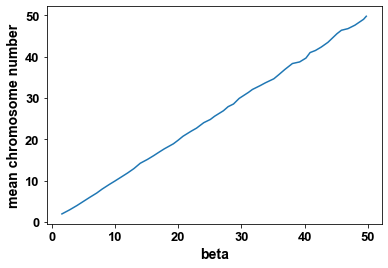

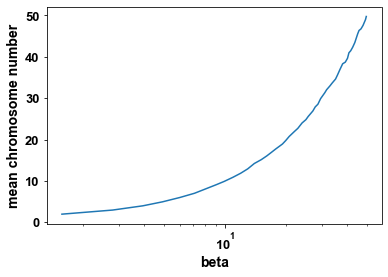

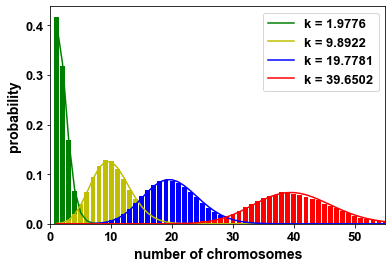

chromosome distribution given 12, sample 6, 12, or 18


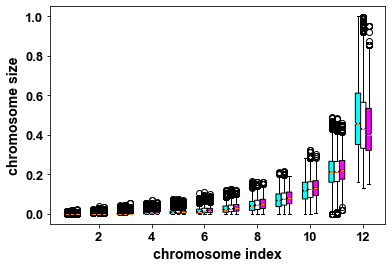

comparison to data


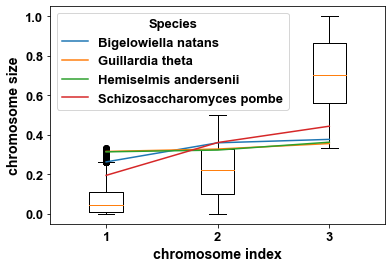

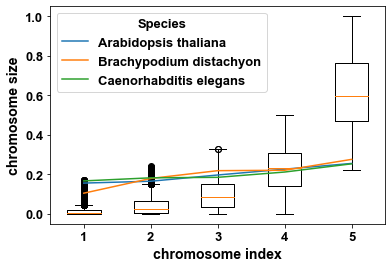

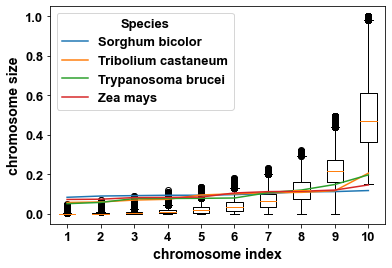

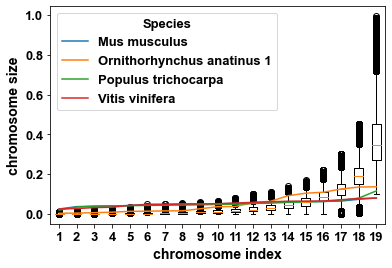

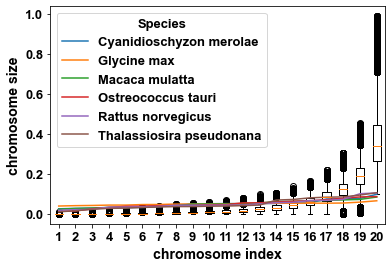

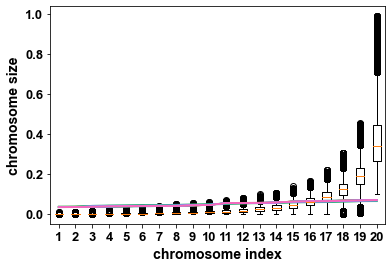

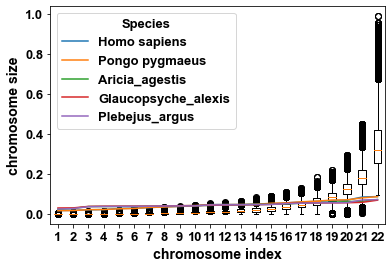

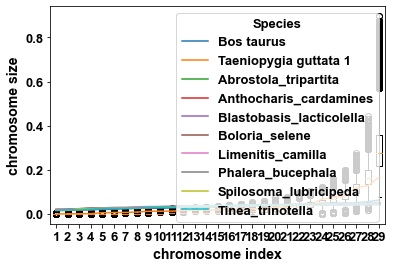

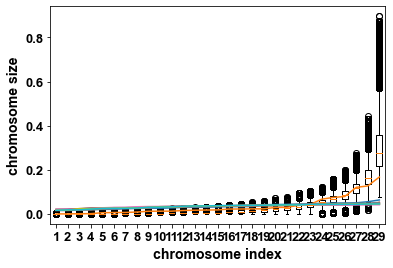

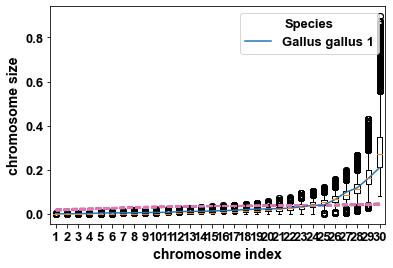

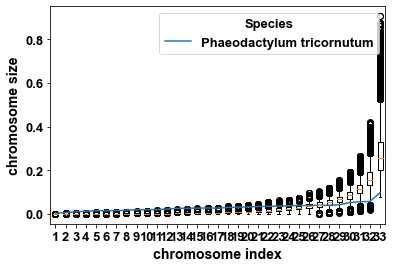

In [29]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

break rate vs mean chromosome number


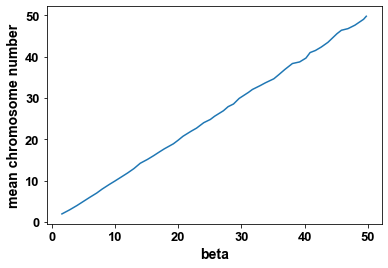

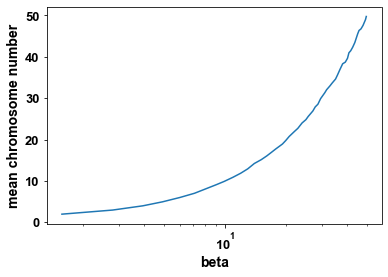

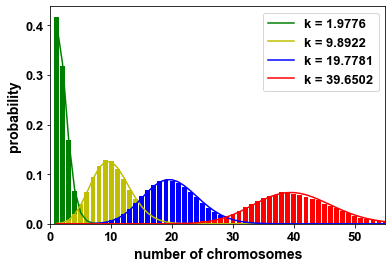

chromosome distribution given 12, sample 6, 12, or 18


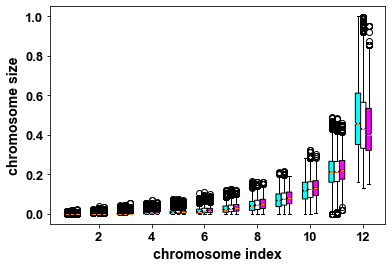

comparison to data


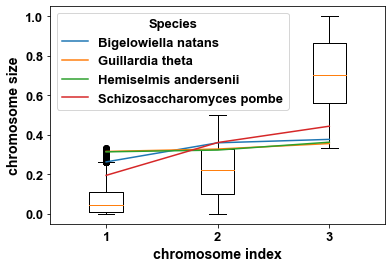

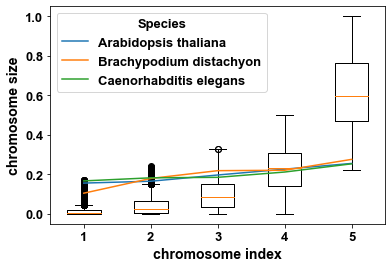

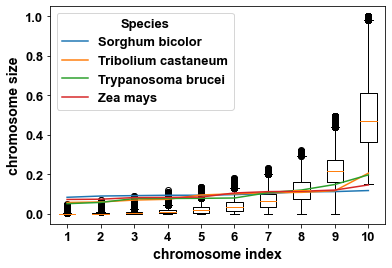

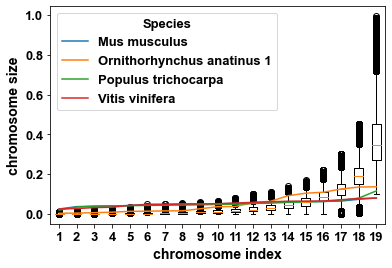

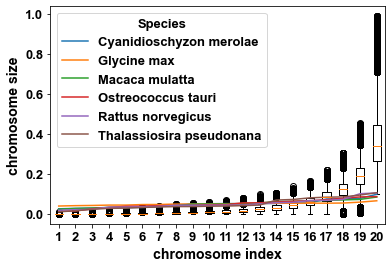

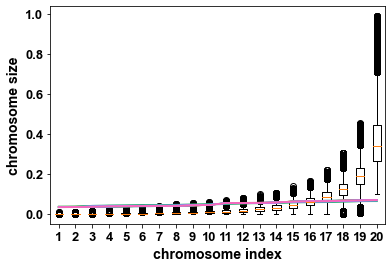

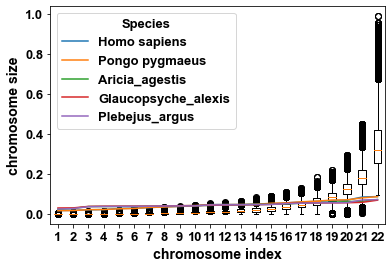

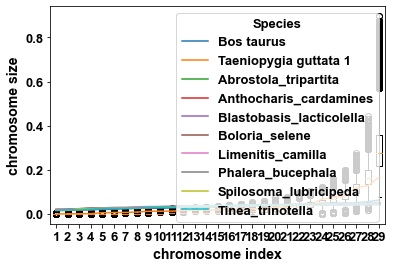

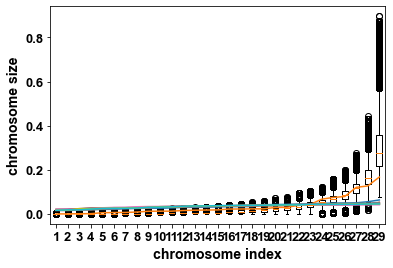

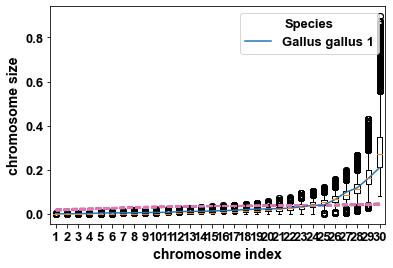

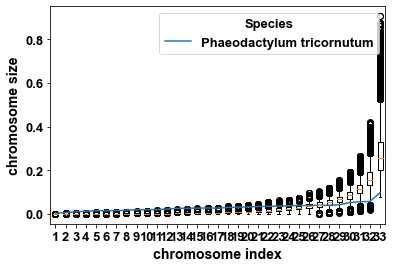

In [29]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

break rate vs mean chromosome number


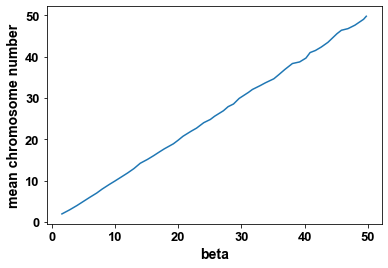

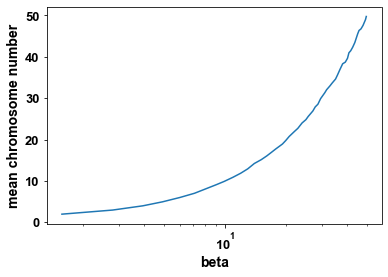

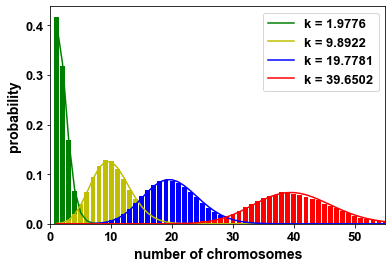

chromosome distribution given 12, sample 6, 12, or 18


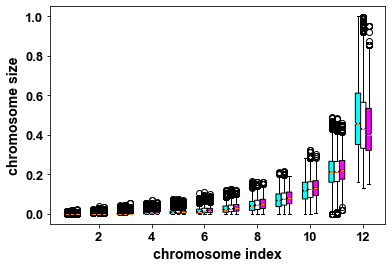

comparison to data


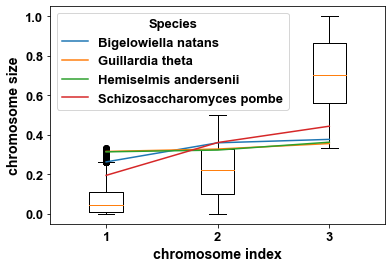

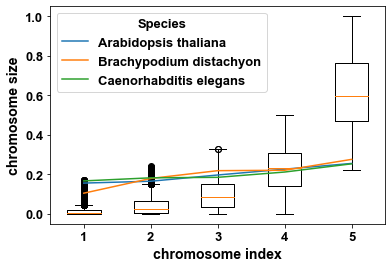

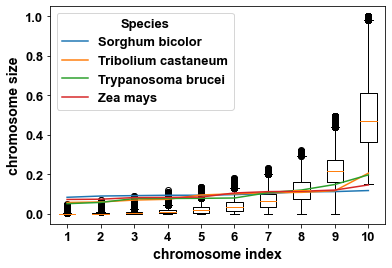

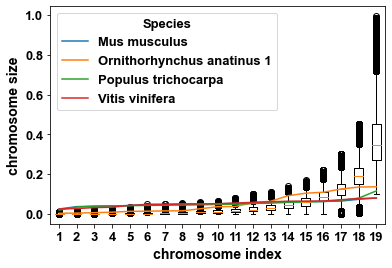

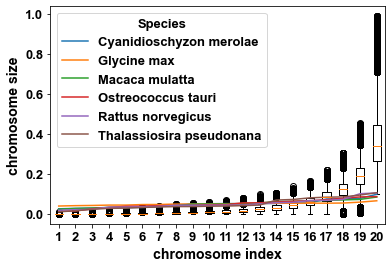

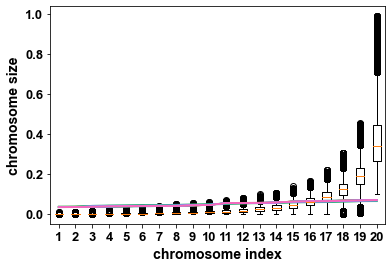

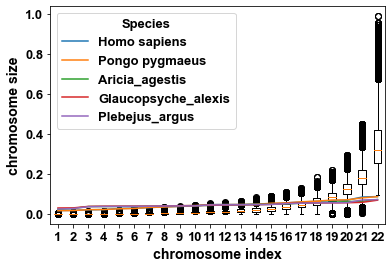

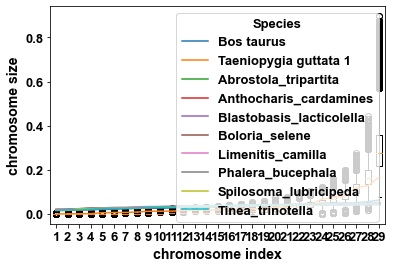

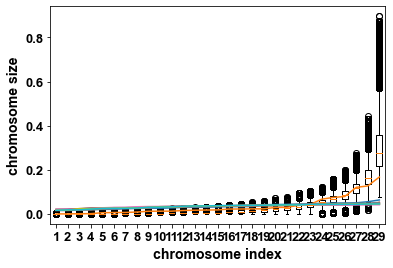

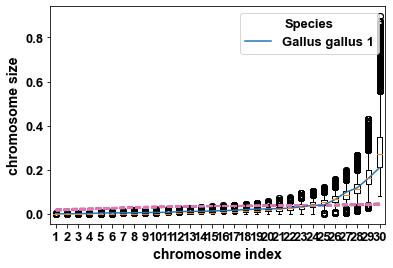

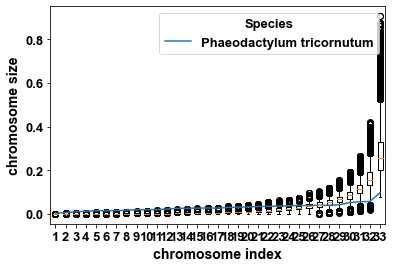

In [29]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## m0: EB/EF With Size Limit

In [13]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()


thisModel_betaList= [2.644626807387653, 5.179417807397722, 7.544738888102072, 9.828935663900818, 12.13707017719976, 14.470388244291229, 16.80440673288128, 19.139758261840687, 21.441354705704995, 23.610786712243602, 25.78021871878221, 27.989469571042946, 30.20320914367589, 32.5482934284346, 34.96723660762173, 37.244091978330665, 39.415085837786904, 41.620351821707615, 43.91829867426852, 46.209192743417205, 48.43219274421418, 50.65519274501115, 52.74088192564205, 54.80136295493311, 56.94537756838253, 59.20556918174402, 61.569988300317505, 64.33596343096366, 66.84898901597361, 68.98003568788988, 71.09975635545528, 73.01352060809154, 74.9272848607278, 77.4769453169824, 80.83765886608037, 82.6320716101659, 84.34698296550187, 86.0762241418138, 88.18817309896745, 90.30012205612111, 92.45766230568115, 94.63779939328137, 97.01660759892452, 99.72628491709814, 102.14012221661221, 104.29154600368362, 106.57392234319738, 109.3613588836937]

thisModel_chrsByBeta = np.load("./simulation_data/m0_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta =np.load("./simulation_data/m0_soft_lim_timesByBeta.npy")

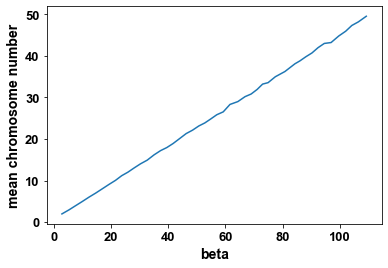

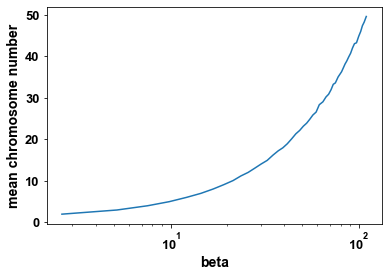

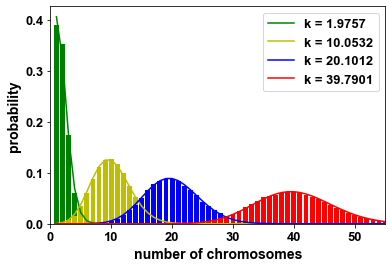

chromosome distribution given 12, sample 6, 12, or 18


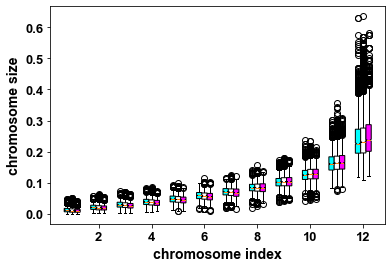

comparison to data


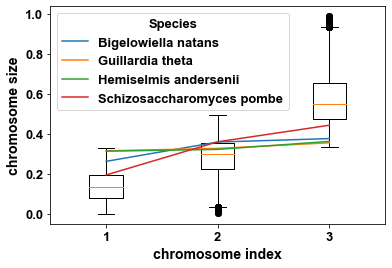

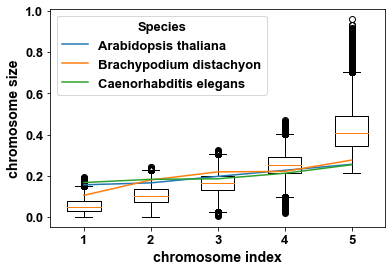

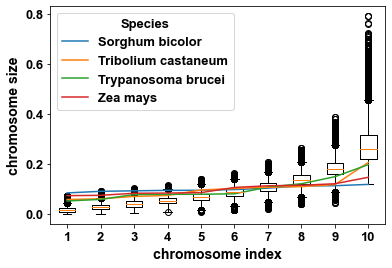

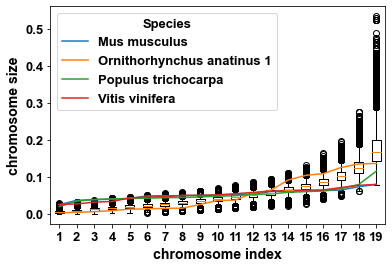

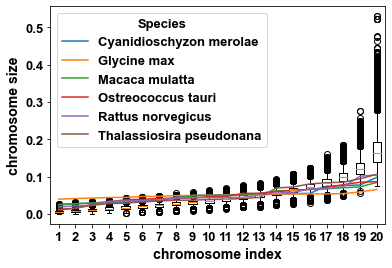

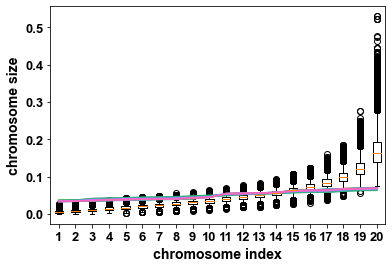

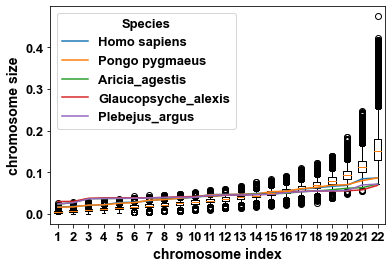

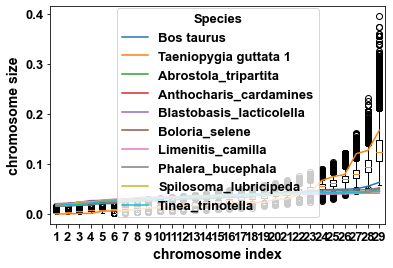

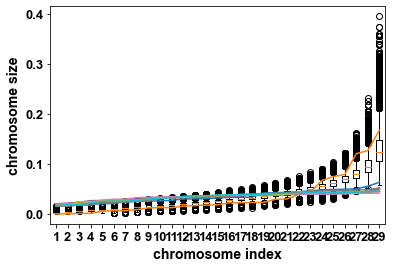

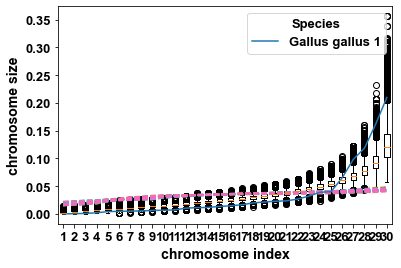

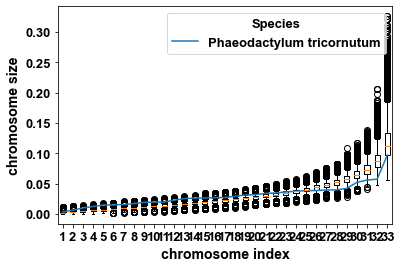

In [18]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

# M1: Proportional Break, Equal Fuse

## M1 with no size limit

From interpolation in previous section, the following beta values approximate simulations with mean chr number = 2, 3, 4, ....

In [31]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()


thisModel_betaList= [2.808681004547339, 7.288295975896768, 13.897055082746881, 22.316582218107683, 32.99174685302006, 45.63715710987134, 59.327786050577714, 76.9490352131573, 94.96472335571887, 116.85470731427627, 137.4475818676636, 161.31432629410799, 188.21368466969747, 219.50739332401787, 249.4884890156581, 281.3626392501229, 315.58140035105106, 351.9206885100354, 388.0250377984629, 432.3951187949515, 470.34336368099093, 517.6507495312305, 564.2862101737827, 612.9757679620348, 661.5727593794625, 717.2628454059655, 773.5108177044572, 828.9617192921482, 889.0849509165514, 948.6706838244477, 1008.4890480488466, 1071.7753955157123, 1135.2008938824058, 1211.0955999241892, 1279.1813789030655, 1354.2576423415137, 1429.6329850729826, 1503.0990060180243, 1579.1442137898225, 1652.136751968472, 1749.07691775005, 1836.5900896047367, 1919.879390957294, 1998.8663973161017, 2082.1101799892413, 2181.568765321909, 2289.9651504477306, 2370.9984324946336, 2457.9312765476993]


thisModel_chrsByBeta = np.load("./simulation_data/m1_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m1_timesByBeta.npy")

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


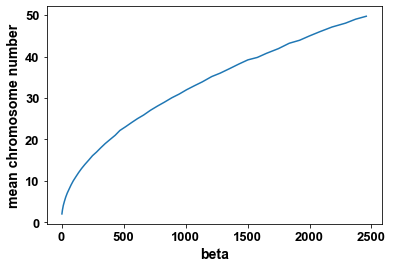

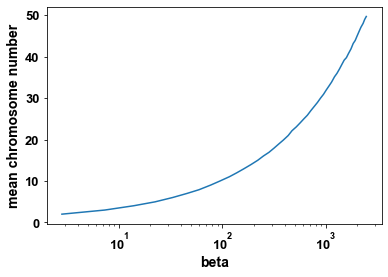

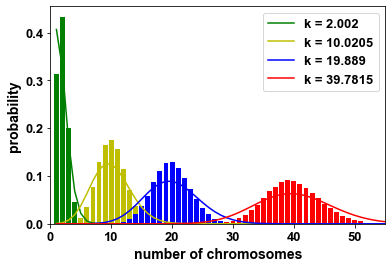

chromosome distribution given 12, sample 6, 12, or 18


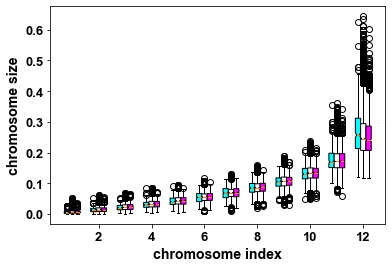

comparison to data


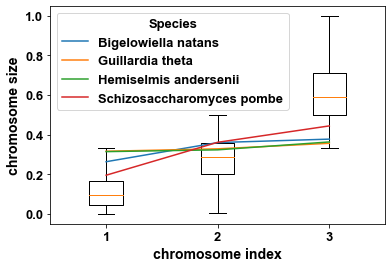

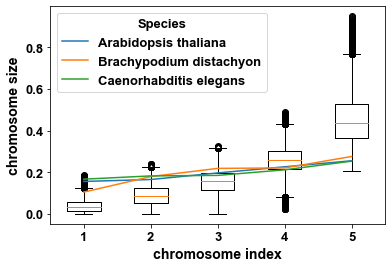

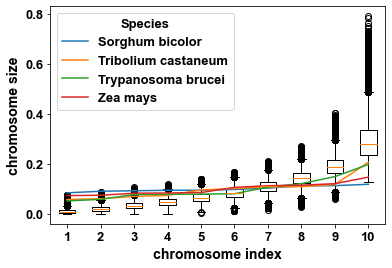

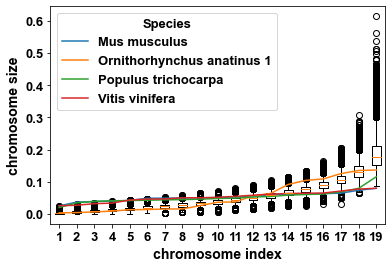

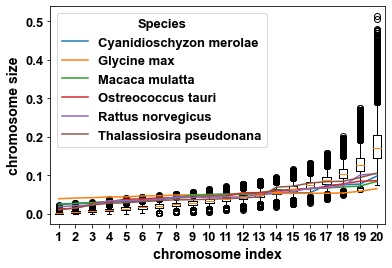

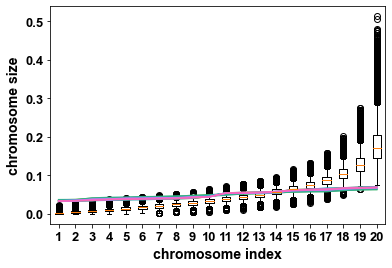

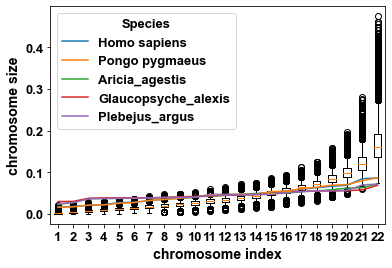

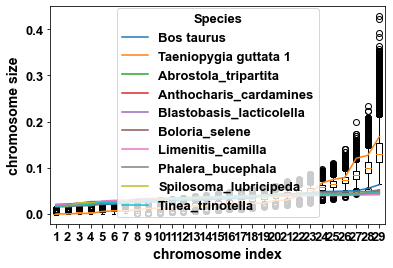

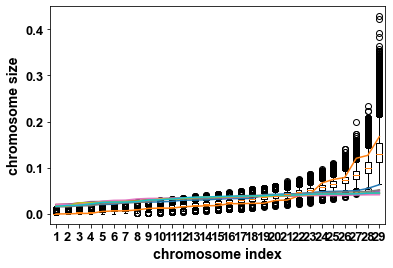

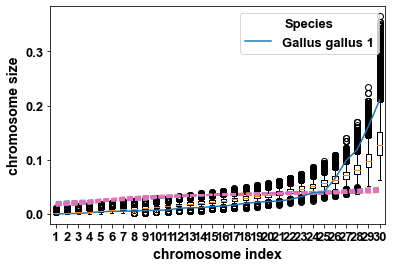

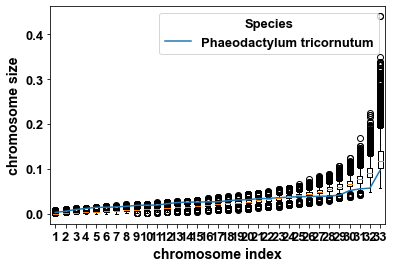

In [25]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## M1 with size limit  

In [40]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()






thisModel_betaList= [4.073650444194416, 10.915102231718965, 20.51952568261933, 33.22968848697082, 48.493908910182626, 66.6290253173398, 89.1128501697647, 114.66193878982692, 144.00058912297428, 173.33923945612162, 203.48238169490733, 241.63495215649056, 279.78752261807375, 320.9145213499595, 365.3927047089655, 412.1081300723231, 466.6673172278267, 522.9398040831145, 581.9027421947767, 641.0699916162304, 700.3412049747548, 762.0373070888566, 826.8215365412035, 896.5453694365185, 978.3974846984527, 1068.0213121157278, 1160.1784122404572, 1252.3355123651868, 1344.4926124899162, 1436.6497126146455, 1528.806812739375, 1620.9639128641045, 1713.1210129888339, 1805.2781131135634, 1897.4352132382928, 1989.5923133630222, 2109.9828863708767, 2233.9679211112943, 2357.952955851712, 2481.937990592129, 2605.923025332547, 2729.9080600729644, 2853.893094813382, 2977.878129553799, 3112.914659399551, 3250.3512692413537, 3387.7878790831564, 3525.224488924959]


thisModel_chrsByBeta = np.load("./simulation_data/m1_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta = np.load("./simulation_data/m1_soft_lim_timesByBeta.npy")


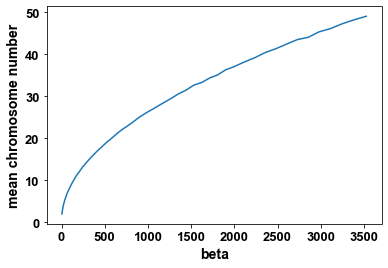

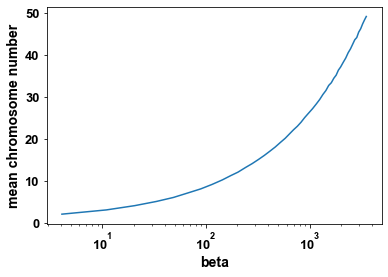

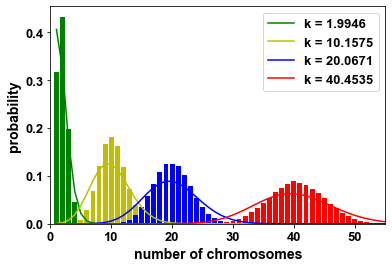

chromosome distribution given 12, sample 6, 12, or 18


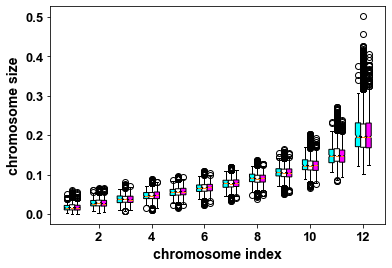

comparison to data


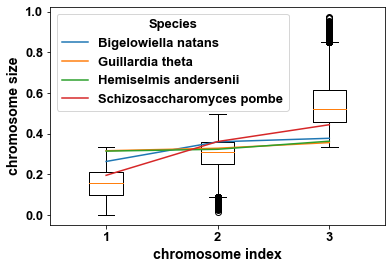

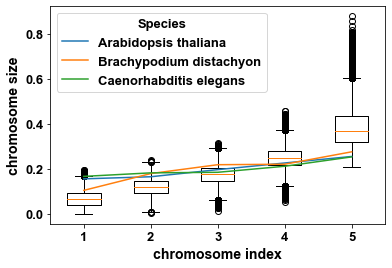

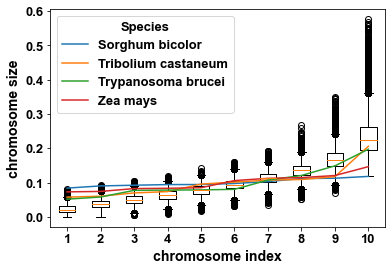

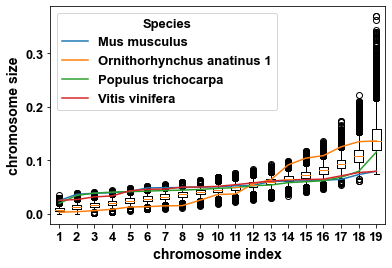

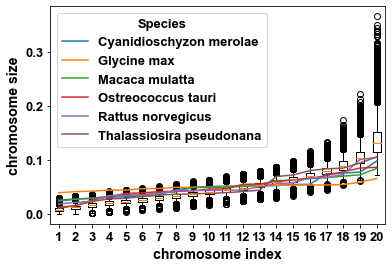

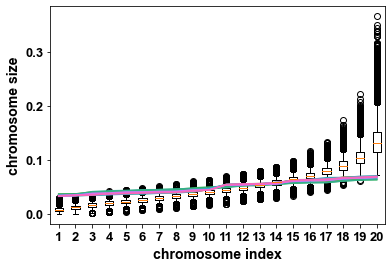

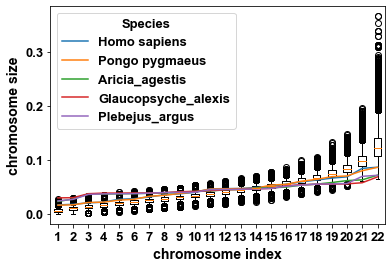

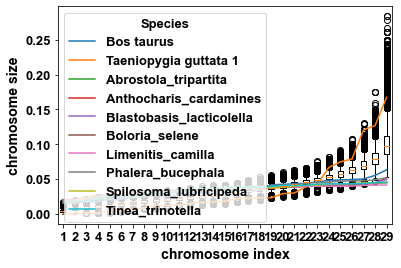

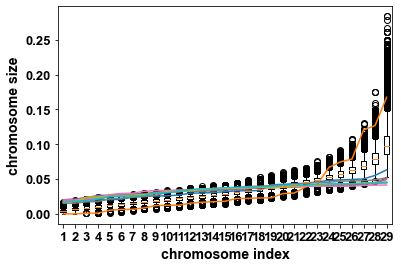

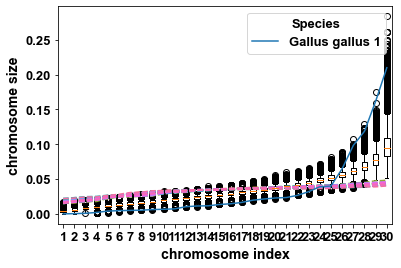

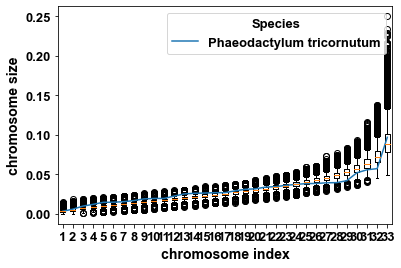

In [33]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

# M2: Equal Break, Proportional Fuse

## M2 with no size limit

In [41]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [23.569471903637325, 88.51862910399996, 221.42325163053314, 453.32329797174566, 778.2867394990128, 1260.1420113235424, 1903.9262680150605, 2770.325690647271, 3811.894878411448, 5136.419668439857, 6602.6723134599215, 8408.395711064022, 10709.914862097252, 13111.445198613095, 15897.610628558881, 18939.6545838087, 22521.670636385144, 26700.072708759995, 31066.811596846732, 36625.53894755928, 41807.06937276224, 47401.54563158042, 53495.231936625045, 60855.730400514425, 69386.96330642577, 78628.88217386992, 86525.4310531263, 95791.61823607811, 106661.09260848518, 117401.02231278268, 128713.21501263673, 142287.96729118365, 157179.3167071051, 170816.52259547662, 183455.41476952864, 198122.99569908384, 216721.76228453944, 233707.99493649928, 252808.39433528378, 276995.3283204419, 295494.0625666956, 318000.0534978342, 342416.86083084816, 359706.8956783678, 381139.7755541611, 413080.691625807, 441607.7564847175, 471891.40287797054, 502604.77833629795]


thisModel_chrsByBeta =  np.load("./simulation_data/m2_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m2_timesByBeta.npy")


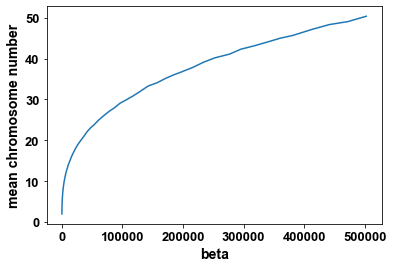

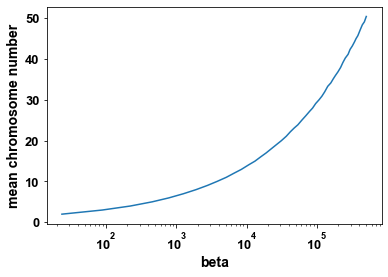

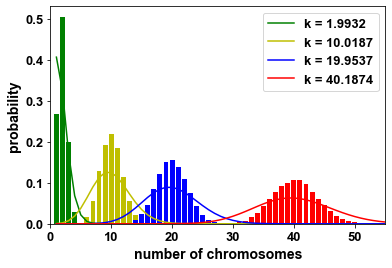

chromosome distribution given 12, sample 6, 12, or 18


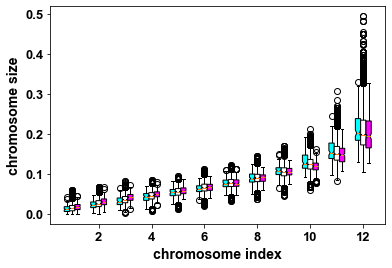

comparison to data


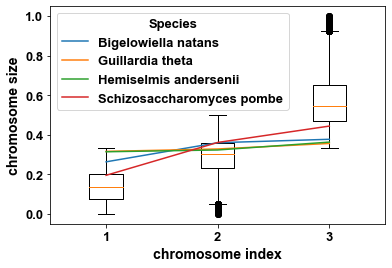

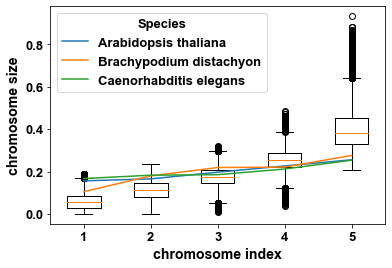

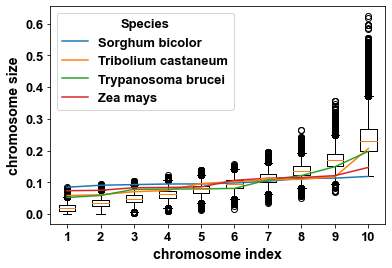

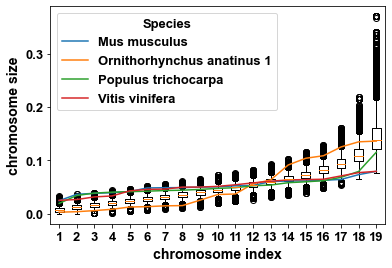

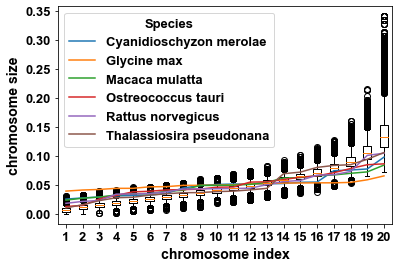

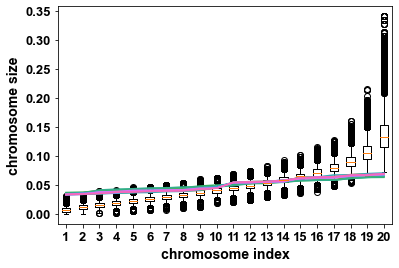

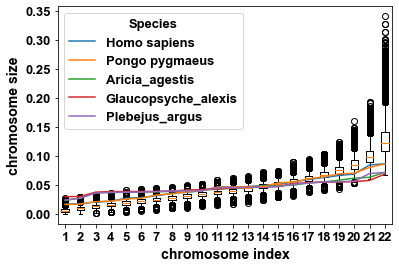

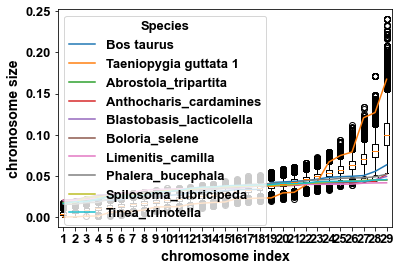

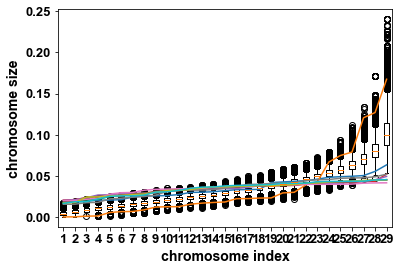

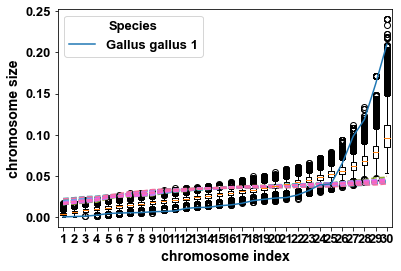

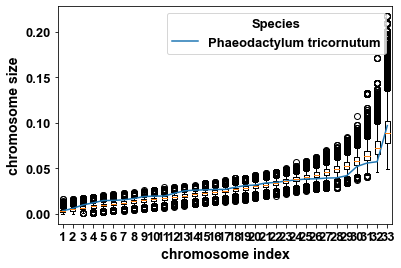

In [42]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## M2 with size limit

In [43]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [29.27934192704531, 112.05455003610655, 275.73514853449575, 559.7138173492411, 1003.8851227454024, 1576.9437496515739, 2421.536456945914, 3411.077388019119, 4756.196780377086, 6271.523998198954, 8239.519372662464, 10506.564134079943, 13138.285880398933, 16076.184438647946, 20009.96536120077, 23530.536898744747, 27916.11745154465, 32847.106914163516, 38799.3764667792, 45370.3005453808, 51636.498838580745, 59421.00289835308, 67309.7284691954, 76792.2695505715, 85549.56254756365, 95270.53457663047, 106527.76413469043, 120101.8163633649, 131765.74753487395, 145204.11590614522, 160201.21783029303, 175360.8976282618, 192626.2088818813, 209531.0808718946, 230569.83340676205, 247737.9468662878, 270274.3944258123, 290717.4581170219, 311600.3805808318, 336008.57727123826, 363220.6493192878, 387747.0251103352, 419807.4726729323, 445768.044546959, 478396.2586570299, 515636.49863793614, 547013.9706987956, 574909.9616558778]

thisModel_chrsByBeta = np.load("./simulation_data/m2_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta = np.load("./simulation_data/m2_soft_lim_timesByBeta.npy")

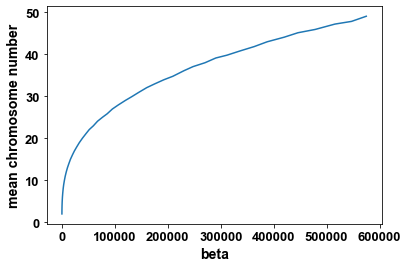

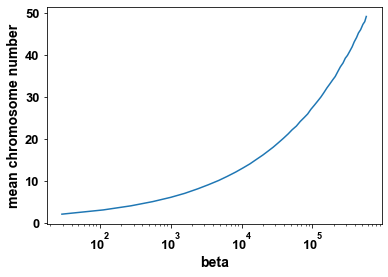

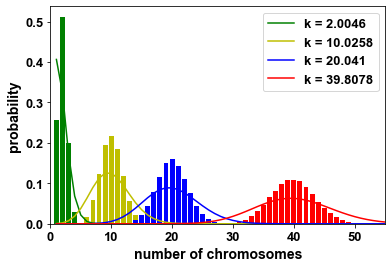

chromosome distribution given 12, sample 6, 12, or 18


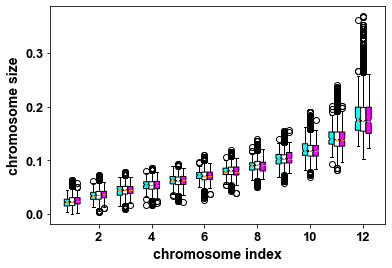

comparison to data


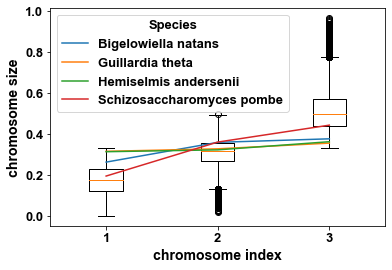

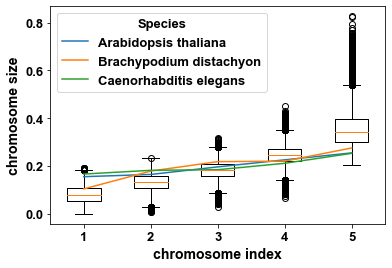

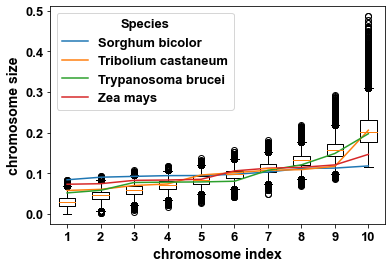

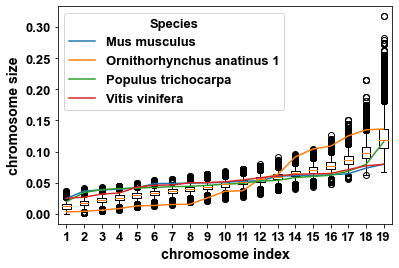

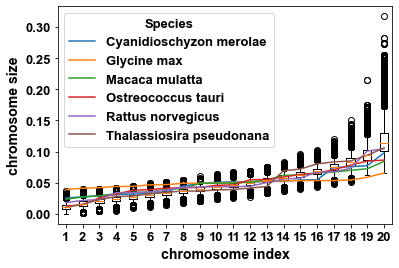

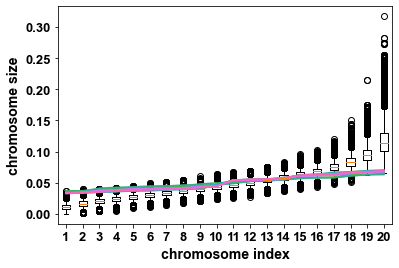

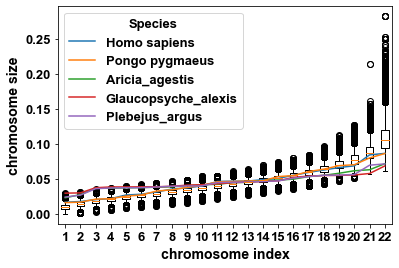

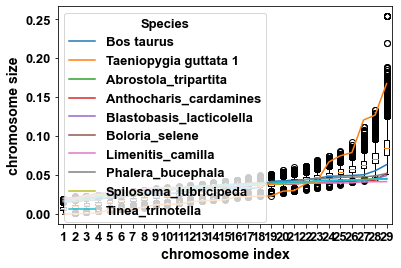

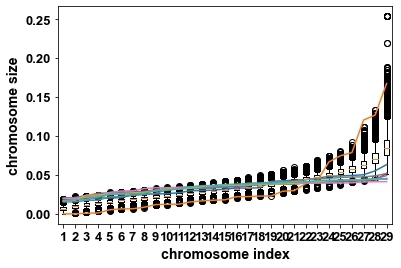

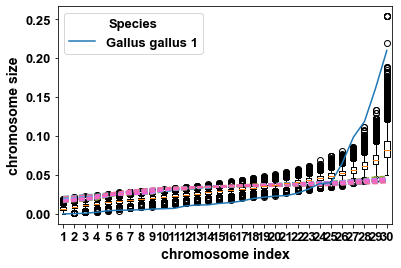

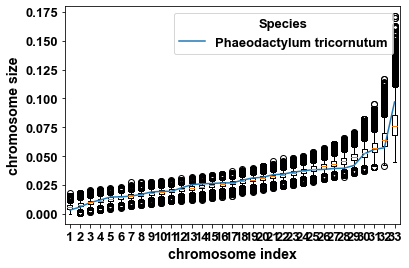

In [44]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

# M3: Proportional Break, Proportional Fuse

## M3 with no size limit

In [46]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [31.774895456757505, 181.1017791809923, 593.3166272461382, 1504.4792442543744, 3166.31977772849, 5941.051024637211, 10202.894108092045, 16523.592721563415, 25433.674585713685, 37157.406076108266, 52193.3241938528, 74025.1697698853, 98935.94346791586, 129906.86626071765, 169736.66178221858, 215573.1150131125, 273064.41493930144, 340148.12798132945, 415618.8392555431, 511460.5916224184, 608600.070301818, 722696.4361615726, 856980.9981954996, 1011806.9488947557, 1202196.2445549064, 1410083.6877459432, 1623172.32615443, 1847345.5701359615, 2106331.9186239555, 2430020.6726351334, 2738806.2012801473, 3164747.609882988, 3496738.0688023563, 3936231.7112589437, 4383618.751981658, 4906135.345138353, 5562759.304010245, 6007118.979906749, 6648234.367655032, 7368026.503044573, 8313235.598992989, 9000612.22451898, 9940866.800296906, 10760084.874523122, 11978644.09607985, 12794486.355606023, 14069402.612325855, 15440782.740466563, 16445539.718811212]

thisModel_chrsByBeta = np.load("./simulation_data/m3_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m3_timesByBeta.npy")


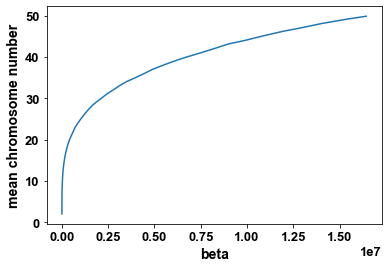

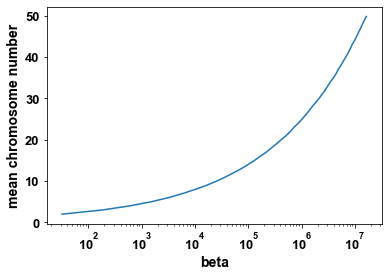

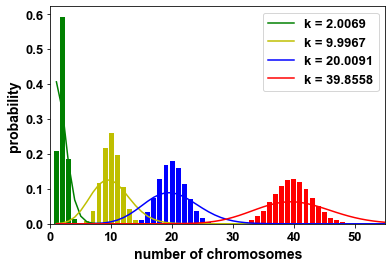

chromosome distribution given 12, sample 6, 12, or 18


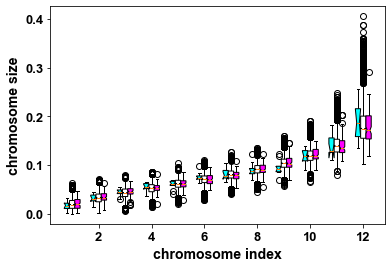

comparison to data


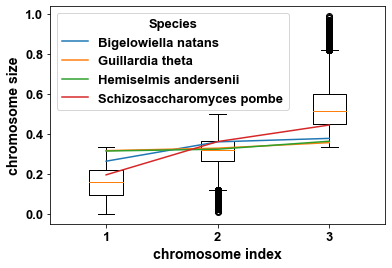

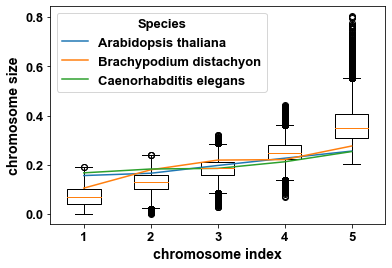

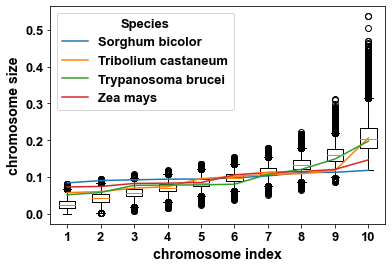

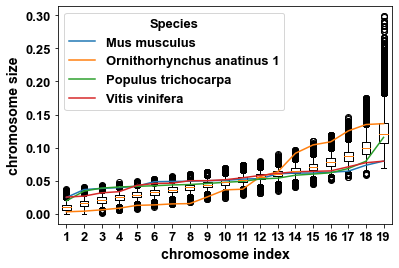

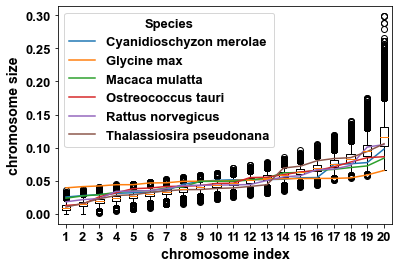

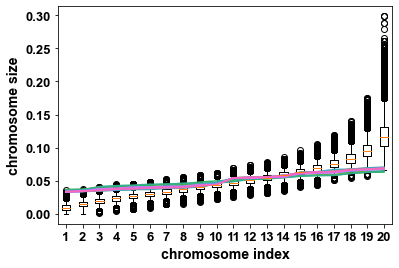

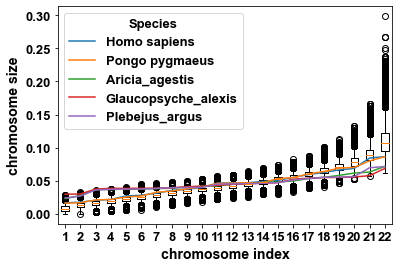

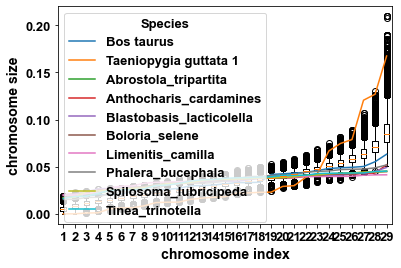

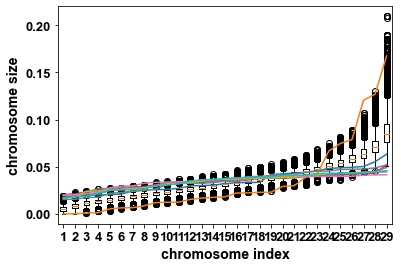

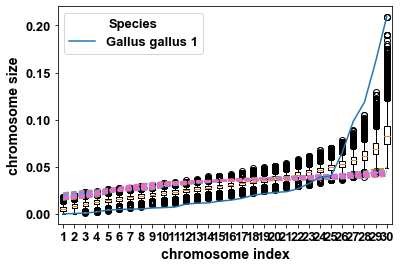

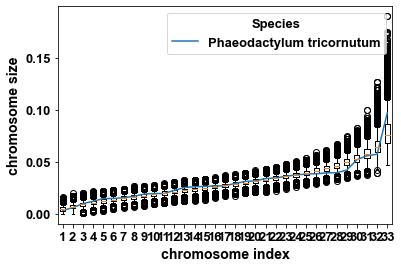

In [47]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## m3 with size limit

In [48]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [39.55576232701653, 222.02908025640033, 743.4924614021129, 1871.131089801183, 3963.873766290852, 7313.717243183733, 13092.056615895623, 20141.620589204147, 31751.14157627478, 46421.93954303279, 65007.17798767411, 90117.71517438962, 126379.12187576346, 166614.1391157379, 209762.68175051012, 267113.05428399076, 336553.3570572479, 423717.8012751485, 517172.4014783773, 624057.0808975651, 751468.7491463138, 899146.7693319485, 1081406.3670153941, 1305363.9649924962, 1529321.5629695985, 1753279.1609467003, 1977236.7589238025, 2316330.0130768074, 2668449.779197487, 3024745.1687654075, 3448345.3457997767, 3871945.522834146, 4382834.3977617035, 4931543.84858048, 5490314.677369995, 6064632.735618526, 6781335.347077144, 7561989.116145807, 8415441.795726085, 9282310.850952247, 10126732.787767159, 11426260.713333346, 12725788.638899533, 14025316.56446572, 15324844.490031905, 16624372.415598093, 17923900.34116428, 19223428.266730465]

thisModel_chrsByBeta = np.load("./simulation_data/m3_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m3_soft_lim_timesByBeta.npy")


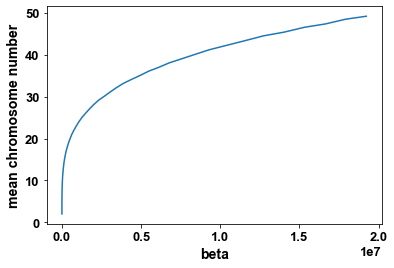

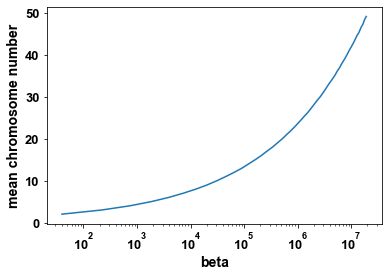

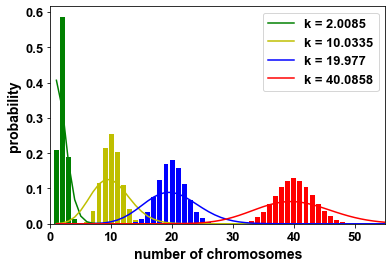

chromosome distribution given 12, sample 6, 12, or 18


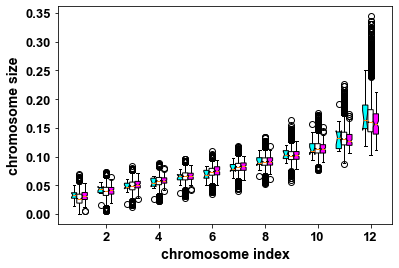

comparison to data


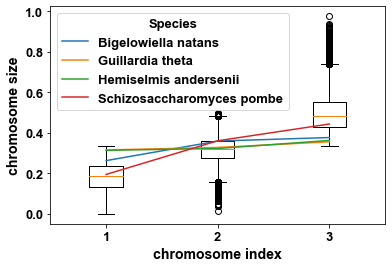

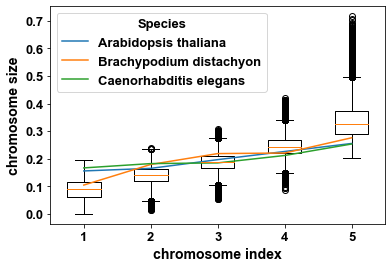

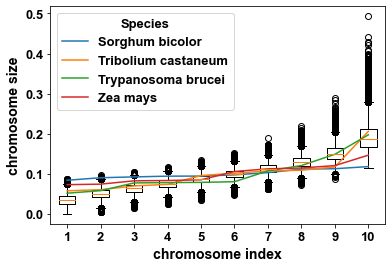

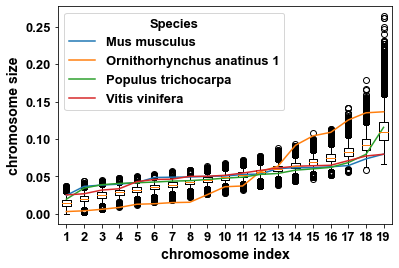

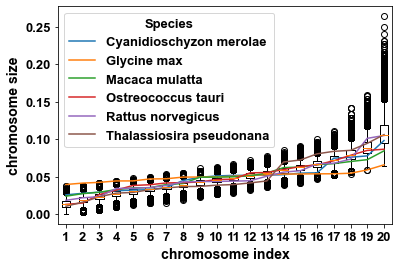

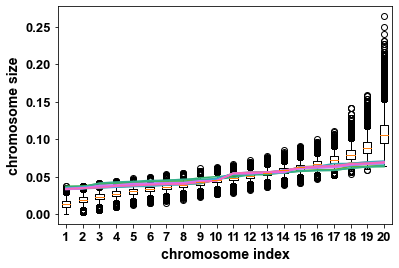

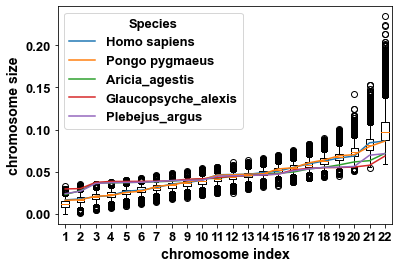

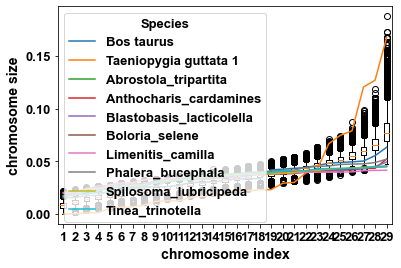

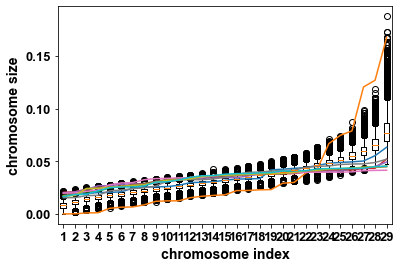

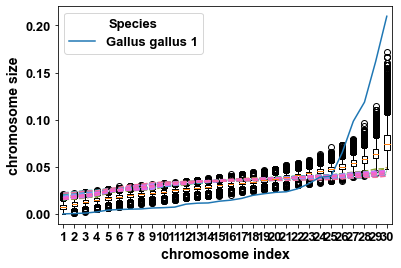

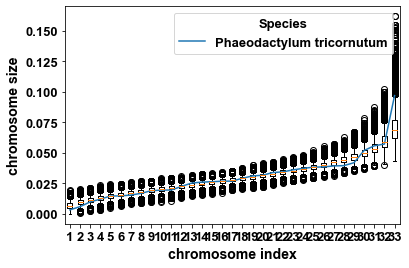

In [49]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

# M4: Equal Break, Short Fuse Big Stick

## m4 EB SFBS no min size

In [50]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList=  [9.829831117436228, 27.808485968977436, 58.77799509151374, 113.83344779968742, 221.40733252364757, 394.39394204442283, 661.9520316394251, 1187.0738691881334, 1948.2853482389341, 3481.9894059438566, 5514.9520069906175, 9670.29713448862, 15693.788719145768, 23440.596352057168, 36268.223667435304, 59093.52412690757, 88142.49842972639, 153779.48701218012, 236755.9324834459, 338768.15072223276, 522758.5548938889, 823332.351348184, 1445498.4864725925, 1807854.8085873048, 2512496.4877292095, 4481390.927213361, 7486302.727045478, 11419994.791985402, 15278125.840048147, 25167439.33236082, 39896955.93760374, 70481784.49602565, 96271391.53692916, 122060998.57783268, 147850605.6187362, 303762266.82786804, 341826777.5001782, 546345508.4116064, 808707959.0173527, 1265435476.6109324, 2093943418.4437628, 2959127402.7299547, 3891471915.778842, 6600810233.244443, 6912910480.198195, 7225010727.151947, 19253710774.838352, 20174557449.49505]

thisModel_chrsByBeta = np.load("./simulation_data/m4_chrsByBeta.npy")
thisModel_timesByBeta = np.load("./simulation_data/m4_timesByBeta.npy")

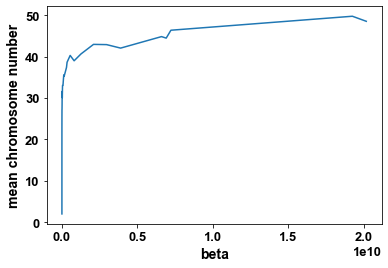

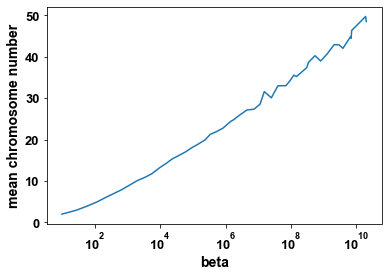

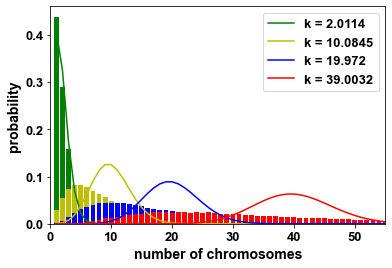

chromosome distribution given 12, sample 6, 12, or 18


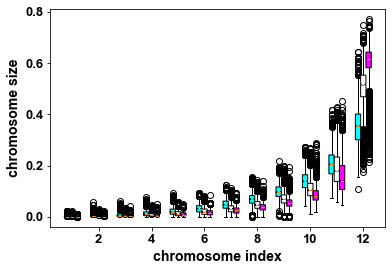

comparison to data


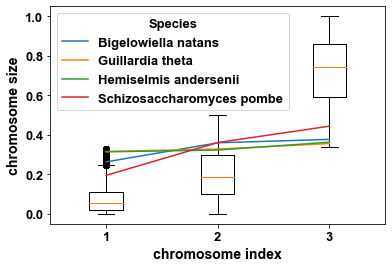

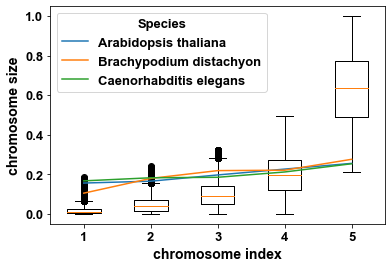

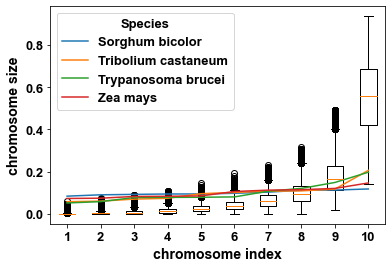

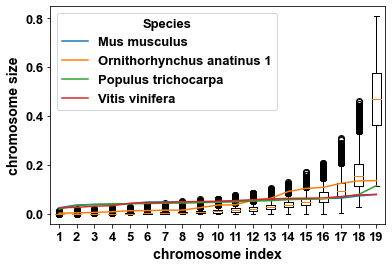

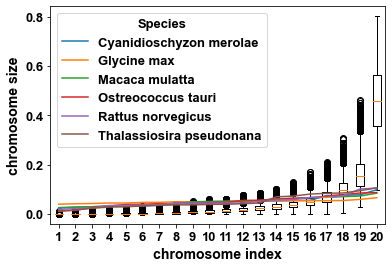

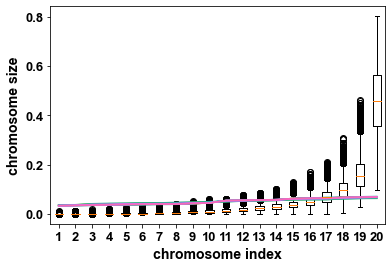

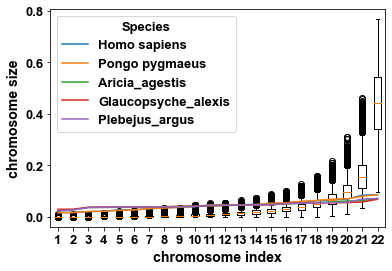

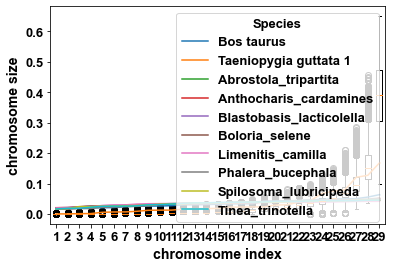

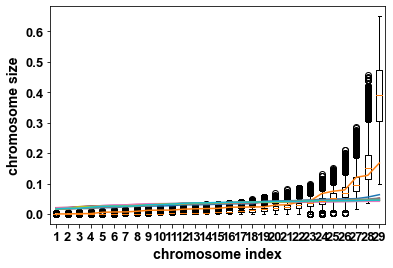

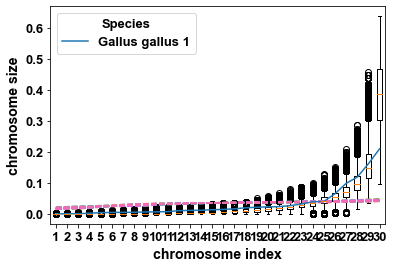

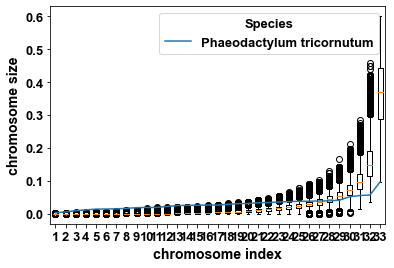

In [51]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## m4 with size limit (EB/SFBS)

In [52]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList=  [9.21431163532861, 21.429375426751555, 37.38550460278229, 57.51107363059687, 86.90089997750248, 126.98333395528016, 184.81949911700823, 266.7505851434506, 382.9666771296113, 558.0221953774312, 784.9254215287622, 1144.4488907546693, 1634.2876636328576, 2121.199344188543, 2837.2599482609157, 3762.7980494202147, 4848.210073436458, 7052.739426376697, 8482.176974002077, 9714.141119297896, 10918.187271255027, 14962.554151424407, 18034.453483415007, 20694.811184908354, 24712.43992501063, 26047.920206358955, 27136.459745807566, 29933.16371755067, 35520.96683088253, 37683.24844110519, 39845.53005132785, 51190.551643650084, 53519.080846863704, 55847.610050077325, 58176.139253290945, 60699.93173516668, 63675.50908281318, 65985.4251220578, 68061.85715987498, 82827.26722146514, 83935.30543363803, 88813.49774778045, 89322.81680721522, 89832.13586664997, 90341.45492608474, 100824.22648123662, 101687.88064152749, 102551.53480181836]

thisModel_chrsByBeta = np.load("./simulation_data/m4_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta = np.load("./simulation_data/m4_soft_lim_timesByBeta.npy")

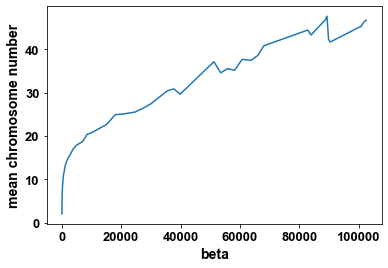

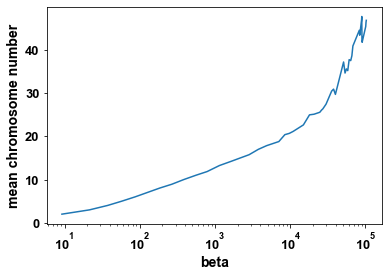

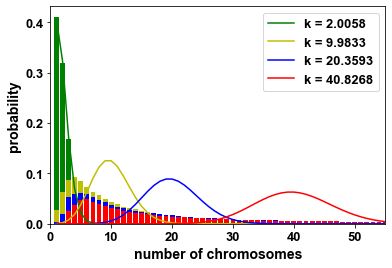

chromosome distribution given 12, sample 6, 12, or 18


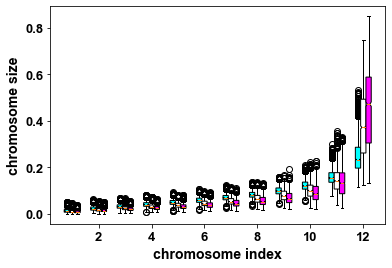

comparison to data


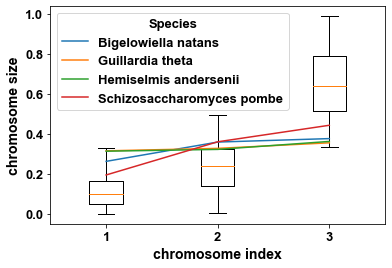

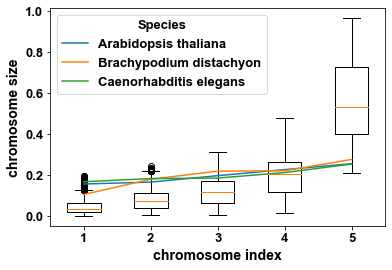

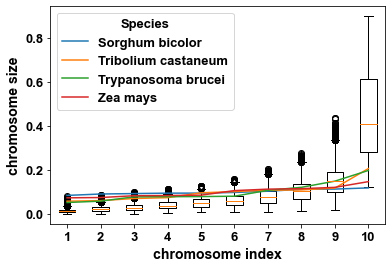

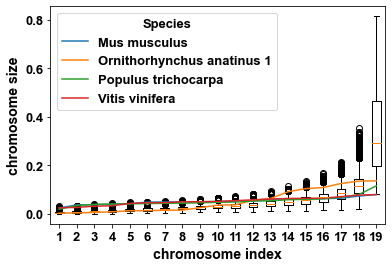

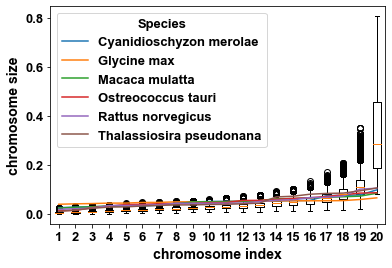

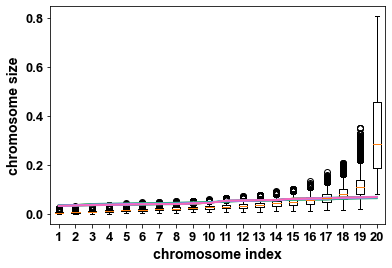

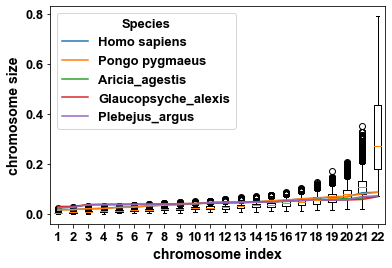

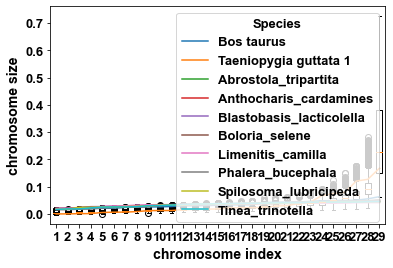

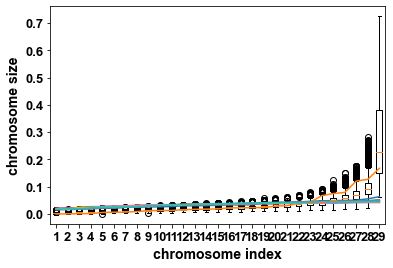

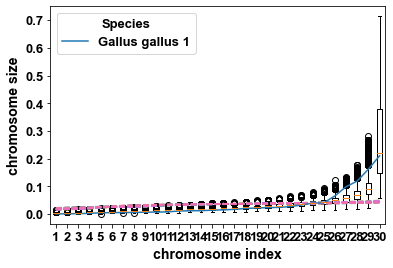

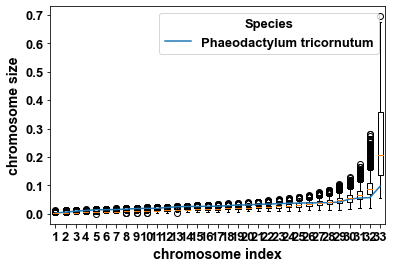

In [53]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

# M5: Proportional Break, Short Fuse Big Stick

## m5 PB SFBS no min size

In [54]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [11.07339377386754, 33.03469514785935, 68.07619070350405, 120.57943284112515, 189.0553620862785, 279.9928203469509, 388.17360944903453, 532.3396924445842, 694.625612651734, 923.1619633861786, 1148.4201874789314, 1487.933435008873, 1854.4507332529365, 2230.734976197197, 2735.1775874513223, 3354.12071036286, 4106.892419117736, 4724.918740805042, 5602.454522490362, 6581.89529071981, 7791.330583737794, 8829.415250732622, 10305.648027204867, 12490.703675019091, 13707.507143713045, 15319.25172219837, 17532.196552065085, 19431.15929612908, 21935.762499958157, 24229.07932805329, 26912.68159375627, 28114.737333725545, 33355.10280280276, 37235.18322981453, 41092.40325921164, 44324.235219508904, 49835.2146862185, 51629.012272836495, 53296.43985278771, 63200.40909515579, 66846.81779279489, 72250.90028189064, 78620.65733092753, 83752.65727085368, 88359.07722351252, 96176.92849789288, 100976.14557506789, 109390.33738142597]

thisModel_chrsByBeta = np.load("./simulation_data/m5_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m5_timesByBeta.npy")

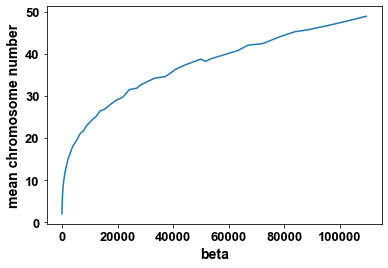

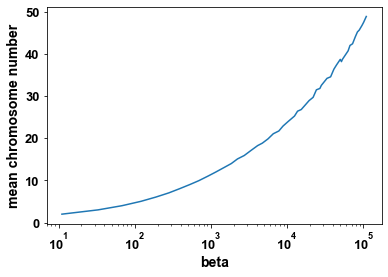

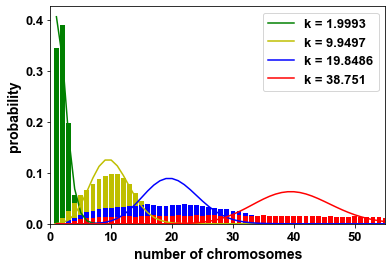

chromosome distribution given 12, sample 6, 12, or 18


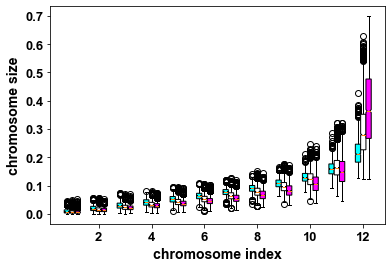

comparison to data


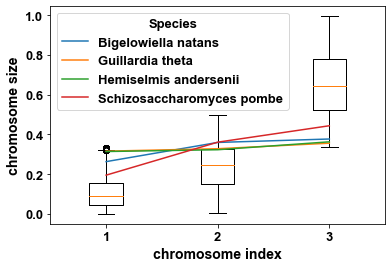

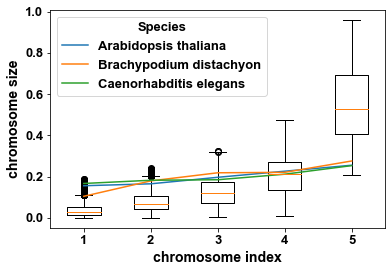

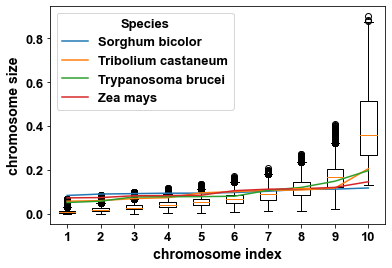

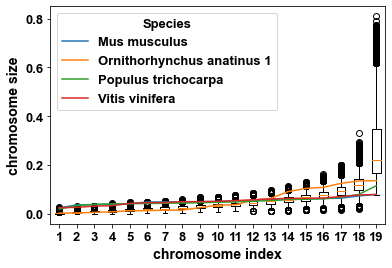

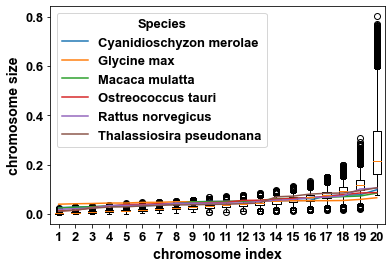

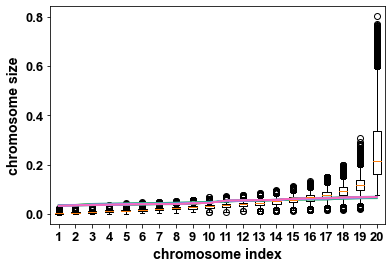

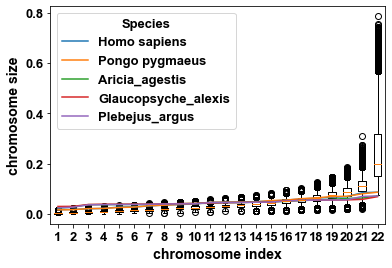

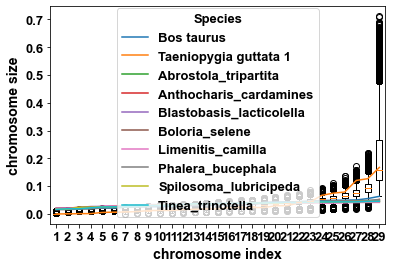

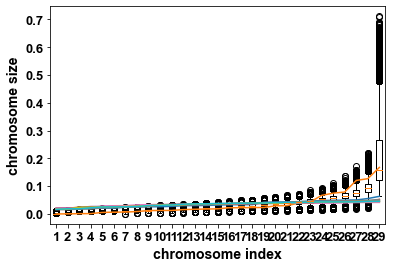

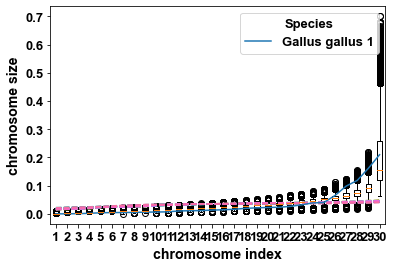

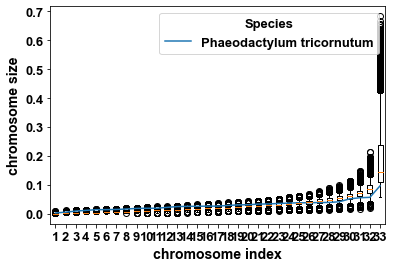

In [55]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)

## m5 PB SFBS WITH min size

In [56]:
try:
    thisModel_chrsByBeta
except: 
    "issue"
else:
    del thisModel_chrsByBeta
    
try:
    thisModel_betaList
except: 
    "issue"
else:
    del thisModel_betaList
    
try:
    thisModel_timesByBeta
except: 
    "issue"
else:
    del thisModel_timesByBeta
    
gc.collect()





thisModel_betaList= [11.61019669215271, 32.980630971711854, 64.36762214953409, 106.73044426685794, 161.35210855374635, 222.1546645644665, 297.7222039683825, 400.85032757955463, 504.61998652762287, 620.6646506746696, 775.9772530098122, 934.9143716902403, 1091.1284189713756, 1355.9262841216787, 1541.994195199646, 1785.5619178601892, 2074.3196245320605, 2378.7148588493, 2660.156771684914, 3005.2432598381974, 3448.331356318798, 4040.062095758765, 4409.46041580059, 4977.412432469067, 5607.003370617122, 6287.098803394049, 6772.678506578415, 7604.717806868524, 8234.47203649243, 9123.501081127832, 9774.17808794476, 10451.49604629894, 11988.515238096737, 12845.215098928751, 13875.274983653217, 14926.233276412944, 16127.759961727836, 17664.136174843832, 18393.808336861555, 20380.754376646684, 21691.075709394237, 22839.263092767033, 23975.164193575874, 25763.22540654768, 27421.005506429112, 28505.687126835826, 30098.245841244807, 32458.150547499372]

thisModel_chrsByBeta = np.load("./simulation_data/m5_soft_lim_chrsByBeta.npy")
thisModel_timesByBeta =  np.load("./simulation_data/m5_soft_lim_timesByBeta.npy")

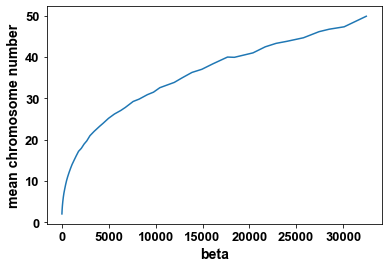

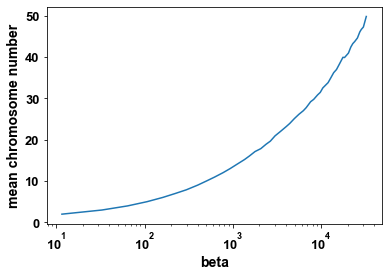

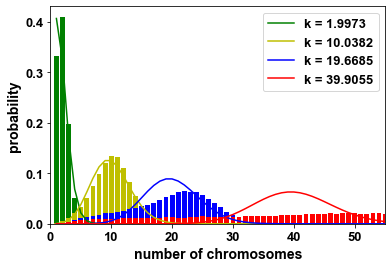

chromosome distribution given 12, sample 6, 12, or 18


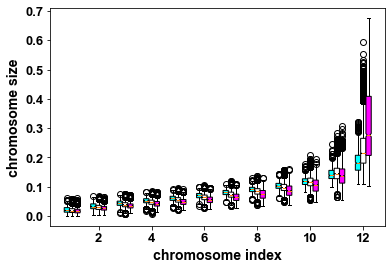

comparison to data


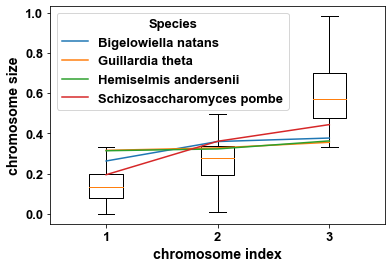

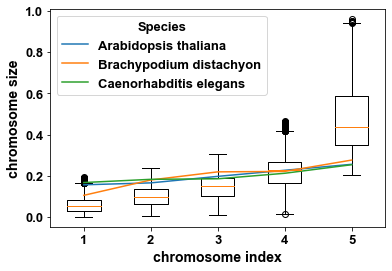

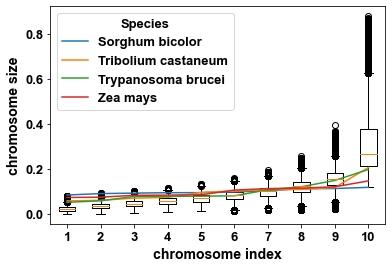

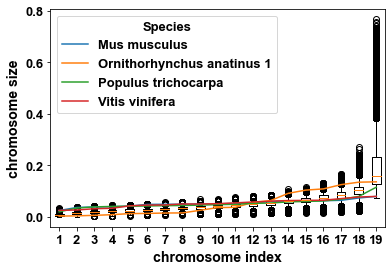

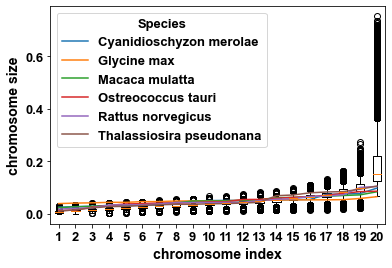

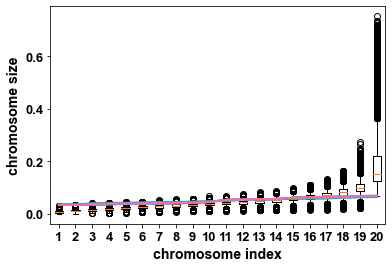

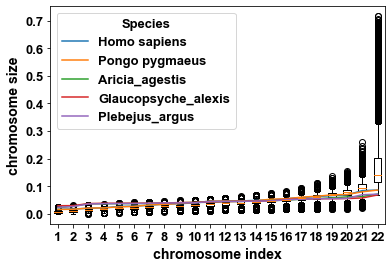

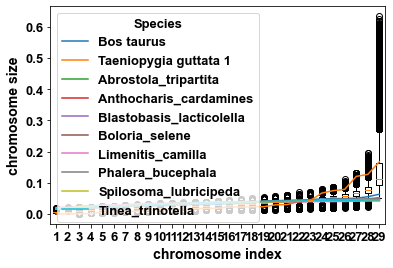

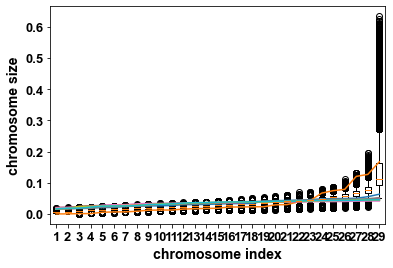

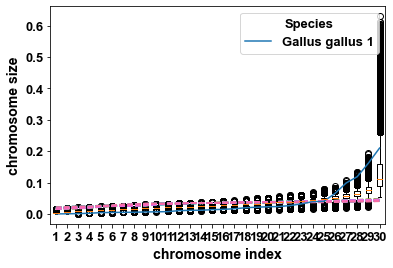

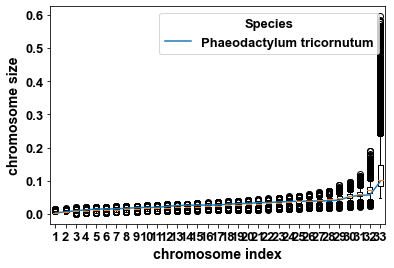

In [57]:
make_figures(thisModel_betaList,thisModel_chrsByBeta,thisModel_timesByBeta)